In [1]:
suppressPackageStartupMessages({
    library(gdata)
    library(singlecellmethods)
    library(matrixStats)
    library(data.table)
    library(viridis)
    library(seaborn)
    library(RColorBrewer)
    library(pheatmap)
    library(Matrix)
    library(harmony)
    library(uwot)
    library(irlba)
    library(Seurat)
    library(factoextra)

    library(msigdbr)
    library(fgsea)
    source('/data/srlab1/mcurtis/spatial_projects/analysis/utils.R')
    source('/data/srlab1/mcurtis/misc_funcs.R')
})


Warning message:
“package ‘RColorBrewer’ was built under R version 4.1.3”
Warning message:
“package ‘Matrix’ was built under R version 4.1.2”
Warning message:
“package ‘Rcpp’ was built under R version 4.1.2”
Warning message:
“package ‘msigdbr’ was built under R version 4.1.3”
Warning message:
“package ‘magrittr’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”


In [2]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.7 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/mc1070/anaconda3/envs/R4.1.1Py3.9.7/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] forcats_0.5.1           stringr_1.4.0           dplyr_1.1.0            
 [4] purrr_0.3.4             readr_2.1.2             tidyr_1.2.0            
 [7] tibble_3.1.8            tidyverse_1.3.1         patchwork_1.1.1        
[10] magrittr_2.0.3         

In [18]:
dge_all = read_delim('../Misc/CD45_lm_Dosage.csv') %>% as.data.frame

Rows: 5544 Columns: 10
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): gene
dbl (9): (Intercept), log10(nUMI.y), PlateP3, PlateP4, Individual_Index10038...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [12]:
dge_all %>% dim

[1] 5544   10

In [13]:
dge_all %>% head(1)

,gene,(Intercept),log10(nUMI.y),PlateP3,PlateP4,Individual_Index10038222,Individual_Index10049338,Dosage,pval,padjBH
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MT-CO2,-3.500619,2.130221,-0.1382712,0.01895425,-0.1622482,-0.03200045,0.060227,0.0190552,0.3968129


# GSEA on just T-cell C7 pathways

In [3]:
category = 'C7'

In [4]:
genesig_df = msigdbr(species = "human", category = category)


In [5]:
genesig_df[['gs_name']] %>% unique %>% length

[1] 5219

In [6]:
include_terms = 'CD4_TCELL|CD4|TREG|TH17|TH1|TH2|TFH'
exclude_terms = 'BCELL|MYELOID|THYMOCYTE|INNATE_LYMPHOID_CELL|POS_DC|WEAK_DC|CD40|PBMC_VS_MEM_CD4_TCELL|HEMATOPOIETIC_STEM_CELL|LYMPHOID_PRIMED_MPP|BASOPHIL|_DC_VS_|EOSINOPHI|MAC_VS|MAST_CELL|NEUTROPHIL|NKCELL|PROGENITOR|LSK|LIN_NEG_VS|NKTCELL'

pathway_names_filt = (genesig_df[['gs_name']] %>% unique)[(grepl(include_terms, 
               genesig_df[['gs_name']] %>% unique))
        &(!grepl(exclude_terms, 
      genesig_df[['gs_name']] %>% unique))]


genesig_df_filt = genesig_df %>% filter(gs_name %in% pathway_names_filt)
genesig_pathways = split(x = genesig_df_filt$gene_symbol, f = genesig_df_filt$gs_name)
pathways = genesig_pathways

In [7]:
length(pathways)

[1] 1111

In [461]:
# Use all genes
name = 'all'
dge = dge_all  

ranks_name = '-sign(dosage)*log10(pval)'
ranks = -1*sign(dge$Dosage)*log10(dge$pval)
names(ranks) = dge$gene
ranks = sort(ranks)

gsea_res = fgsea(pathways = pathways, 
              stats    = ranks,
              minSize  = 15,
              maxSize  = 500)

res = gsea_res %>% as.data.frame

In [466]:
((res %>% filter(padj < 0.05))['NES']>0 )%>% table

.
FALSE  TRUE 
   21    28 

In [462]:
res %>% filter(padj < 0.05) %>% select(-leadingEdge) %>% arrange(desc(NES))

pathway,pval,padj,log2err,ES,NES,size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
GSE2770_IL12_AND_TGFB_ACT_VS_ACT_CD4_TCELL_6H_DN,2.595037e-07,0.0001415593,0.6749629,0.5463462,2.011244,128
GSE24634_TREG_VS_TCONV_POST_DAY5_IL4_CONVERSION_UP,1.304611e-07,0.0001415593,0.6901325,0.5347638,1.991720,142
GSE18893_TCONV_VS_TREG_24H_TNF_STIM_UP,1.722756e-06,0.0003759054,0.6435518,0.5118057,1.914023,146
GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN,7.864419e-07,0.0002145020,0.6594444,0.5065727,1.900967,150
GSE23505_IL6_IL1_VS_IL6_IL1_TGFB_TREATED_CD4_TCELL_DN,1.181250e-05,0.0018410621,0.5933255,0.5101345,1.865560,122
GSE40274_CTRL_VS_XBP1_TRANSDUCED_ACTIVATED_CD4_TCELL_DN,7.803067e-05,0.0050077331,0.5384341,0.5155447,1.806357,87
GSE36476_CTRL_VS_TSST_ACT_72H_MEMORY_CD4_TCELL_OLD_DN,3.797313e-05,0.0029591920,0.5573322,0.4743059,1.776126,147
GSE22886_NAIVE_CD4_TCELL_VS_12H_ACT_TH1_DN,2.521343e-05,0.0029591920,0.5756103,0.4707190,1.761354,145
GSE3982_CENT_MEMORY_CD4_TCELL_VS_TH1_DN,3.672803e-05,0.0029591920,0.5573322,0.4703952,1.758672,144


In [476]:
res_filt = res %>% filter(padj < 0.05)  %>% arrange(desc(NES))
rownames(res_filt) = res_filt$pathway
res_filt['rank'] = seq(1, dim(res_filt)[1])
res_filt['rev_rank'] = rev(res_filt[['rank']])

res_filt[['pathway_label']] = res_filt[['pathway']] %>% str_split('_', n = 2) %>% map(2) %>% unlist

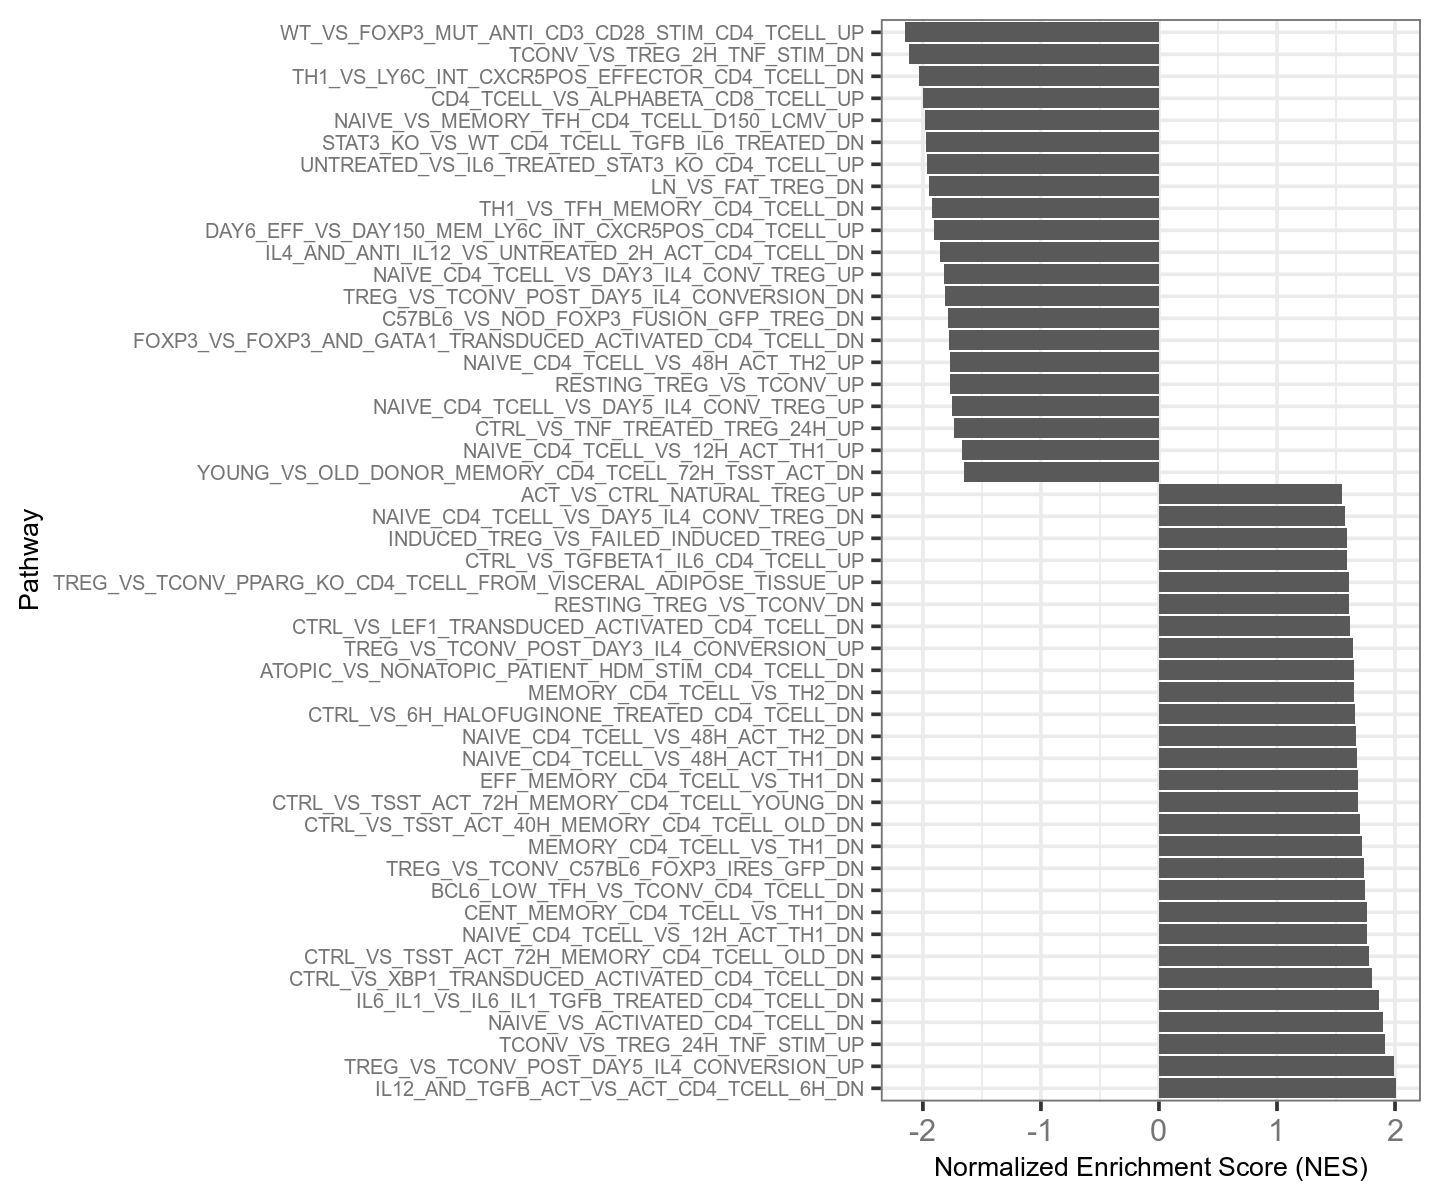

In [558]:
fig.size(10, 12)
ggplot(res_filt)+
    geom_bar(aes(x = NES, y = as.factor(rank)), stat = 'identity')+
    scale_y_discrete(labels = res_filt[['pathway_label']])+
    ylab('Pathway')+
    xlab('Normalized Enrichment Score (NES)')+
    theme_pres()+
    theme(axis.text.y = element_text(size = 12), 
          axis.title.x = element_text(size = 16),axis.title.y = element_text(size = 16),
         )

    

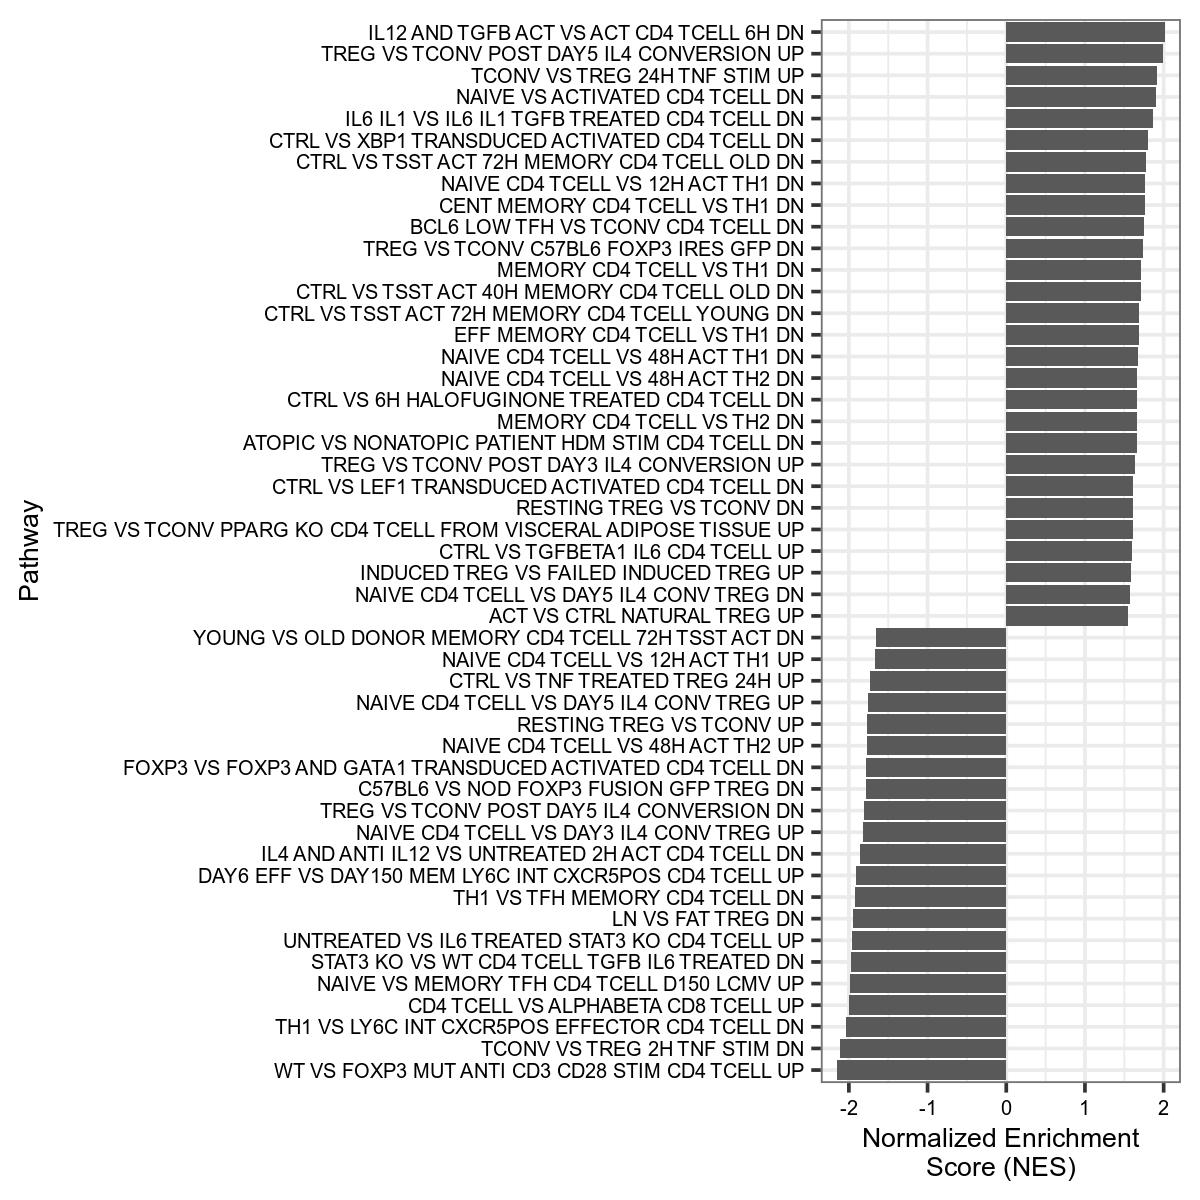

In [736]:
# pdf(file = '../Figures/GSEA_CD45_All.pdf', width = 10, height = 10)

fig.size(10, 10)
ggplot(res_filt)+
    geom_bar(aes(x = NES, y = as.factor(rev_rank)), stat = 'identity')+
    scale_y_discrete(labels = rev(res_filt[['pathway_label']]) %>% str_replace_all('_', ' '))+
    ylab('Pathway')+
    xlab('Normalized Enrichment\nScore (NES)')+
    theme_pres()+
    theme(axis.text.y = element_text(size = 12, color = 'black'), 
          axis.text.x = element_text(size = 12, color = 'black'), 
          axis.title.x = element_text(size = 16),axis.title.y = element_text(size = 16),
         )

# dev.off()

In [608]:
res_filt %>% select(-leadingEdge) %>% head(20)

,pathway,pval,padj,log2err,ES,NES,size,rank,pathway_label,rev_rank
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<int>
1,GSE2770_IL12_AND_TGFB_ACT_VS_ACT_CD4_TCELL_6H_DN,2.595037e-07,0.0001415593,0.6749629,0.5463462,2.011244,128,1,IL12_AND_TGFB_ACT_VS_ACT_CD4_TCELL_6H_DN,49
2,GSE24634_TREG_VS_TCONV_POST_DAY5_IL4_CONVERSION_UP,1.304611e-07,0.0001415593,0.6901325,0.5347638,1.991720,142,2,TREG_VS_TCONV_POST_DAY5_IL4_CONVERSION_UP,48
3,GSE18893_TCONV_VS_TREG_24H_TNF_STIM_UP,1.722756e-06,0.0003759054,0.6435518,0.5118057,1.914023,146,3,TCONV_VS_TREG_24H_TNF_STIM_UP,47
4,GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN,7.864419e-07,0.0002145020,0.6594444,0.5065727,1.900967,150,4,NAIVE_VS_ACTIVATED_CD4_TCELL_DN,46
5,GSE23505_IL6_IL1_VS_IL6_IL1_TGFB_TREATED_CD4_TCELL_DN,1.181250e-05,0.0018410621,0.5933255,0.5101345,1.865560,122,5,IL6_IL1_VS_IL6_IL1_TGFB_TREATED_CD4_TCELL_DN,45
6,GSE40274_CTRL_VS_XBP1_TRANSDUCED_ACTIVATED_CD4_TCELL_DN,7.803067e-05,0.0050077331,0.5384341,0.5155447,1.806357,87,6,CTRL_VS_XBP1_TRANSDUCED_ACTIVATED_CD4_TCELL_DN,44
7,GSE36476_CTRL_VS_TSST_ACT_72H_MEMORY_CD4_TCELL_OLD_DN,3.797313e-05,0.0029591920,0.5573322,0.4743059,1.776126,147,7,CTRL_VS_TSST_ACT_72H_MEMORY_CD4_TCELL_OLD_DN,43
8,GSE22886_NAIVE_CD4_TCELL_VS_12H_ACT_TH1_DN,2.521343e-05,0.0029591920,0.5756103,0.4707190,1.761354,145,8,NAIVE_CD4_TCELL_VS_12H_ACT_TH1_DN,42
9,GSE3982_CENT_MEMORY_CD4_TCELL_VS_TH1_DN,3.672803e-05,0.0029591920,0.5573322,0.4703952,1.758672,144,9,CENT_MEMORY_CD4_TCELL_VS_TH1_DN,41


In [689]:
plotEnrichment_mod <- function (pathway, stats, gseaParam = 1, ticksSize = 0.2) 
{
    rnk <- rank(-stats)
    ord <- order(rnk)
    statsAdj <- stats[ord]
    statsAdj <- sign(statsAdj) * (abs(statsAdj)^gseaParam)
    statsAdj <- statsAdj/max(abs(statsAdj))
    pathway <- unname(as.vector(na.omit(match(pathway, names(statsAdj)))))
    pathway <- sort(pathway)
    gseaRes <- calcGseaStat(statsAdj, selectedStats = pathway, 
        returnAllExtremes = TRUE)
    bottoms <- gseaRes$bottoms
    tops <- gseaRes$tops
    n <- length(statsAdj)
    xs <- as.vector(rbind(pathway - 1, pathway))
    ys <- as.vector(rbind(bottoms, tops))
    toPlot <- data.frame(x = c(0, xs, n + 1), y = c(0, ys, 0))
    diff <- (max(tops) - min(bottoms))/8
    x = y = NULL
    g <- ggplot(toPlot, aes(x = x, y = y)) + geom_point(color = "green", 
        size = 1) + geom_hline(yintercept = max(tops), colour = "black", 
        linetype = "dashed") + geom_hline(yintercept = min(bottoms), 
        colour = "black", linetype = "dashed") + geom_hline(yintercept = 0, 
        colour = "black") + geom_line(color = "green", size = 1) + theme_bw() + 
        geom_segment(data = data.frame(x = pathway), mapping = aes(x = x, 
            y = -diff/2, xend = x, yend = diff/2), size = ticksSize) + 
        theme(panel.border = element_blank(), panel.grid.minor = element_blank(),
              axis.text = element_text(size =17), axis.title =  element_text(size = 17), 
              title = element_text(size = 17)
             ) + 
        labs(x = "Rank", y = "Enrichment Score (ES)")
    g
}


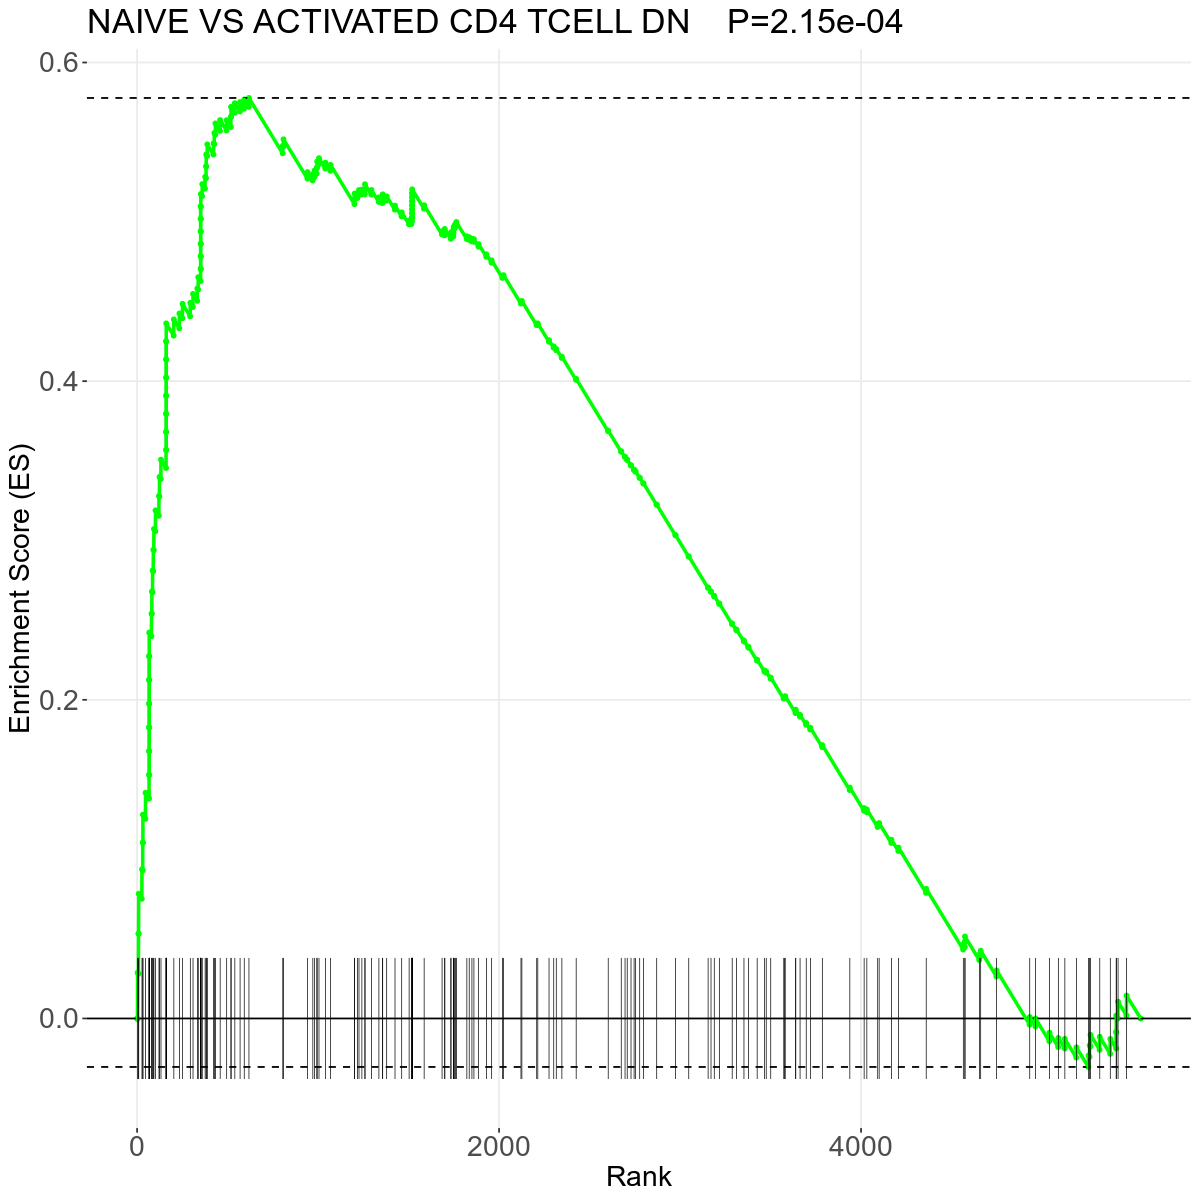

In [735]:
# pdf(file = '../Figures/GSEA_CD45_Naive_VS_Activated.pdf', width = 8, height = 5)
pname = 'GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN'

p = plotEnrichment_mod(pathways[[pname]],
                   ranks) + 
    labs(title=paste0(pname %>% str_split('_', n = 2) %>% map(2) %>% unlist, '    P=', 
       res_filt[pname, 'padj'] %>% formatC(format = "e", digits = 2)) %>% str_replace_all('_', ' ')
        )
p

# dev.off()

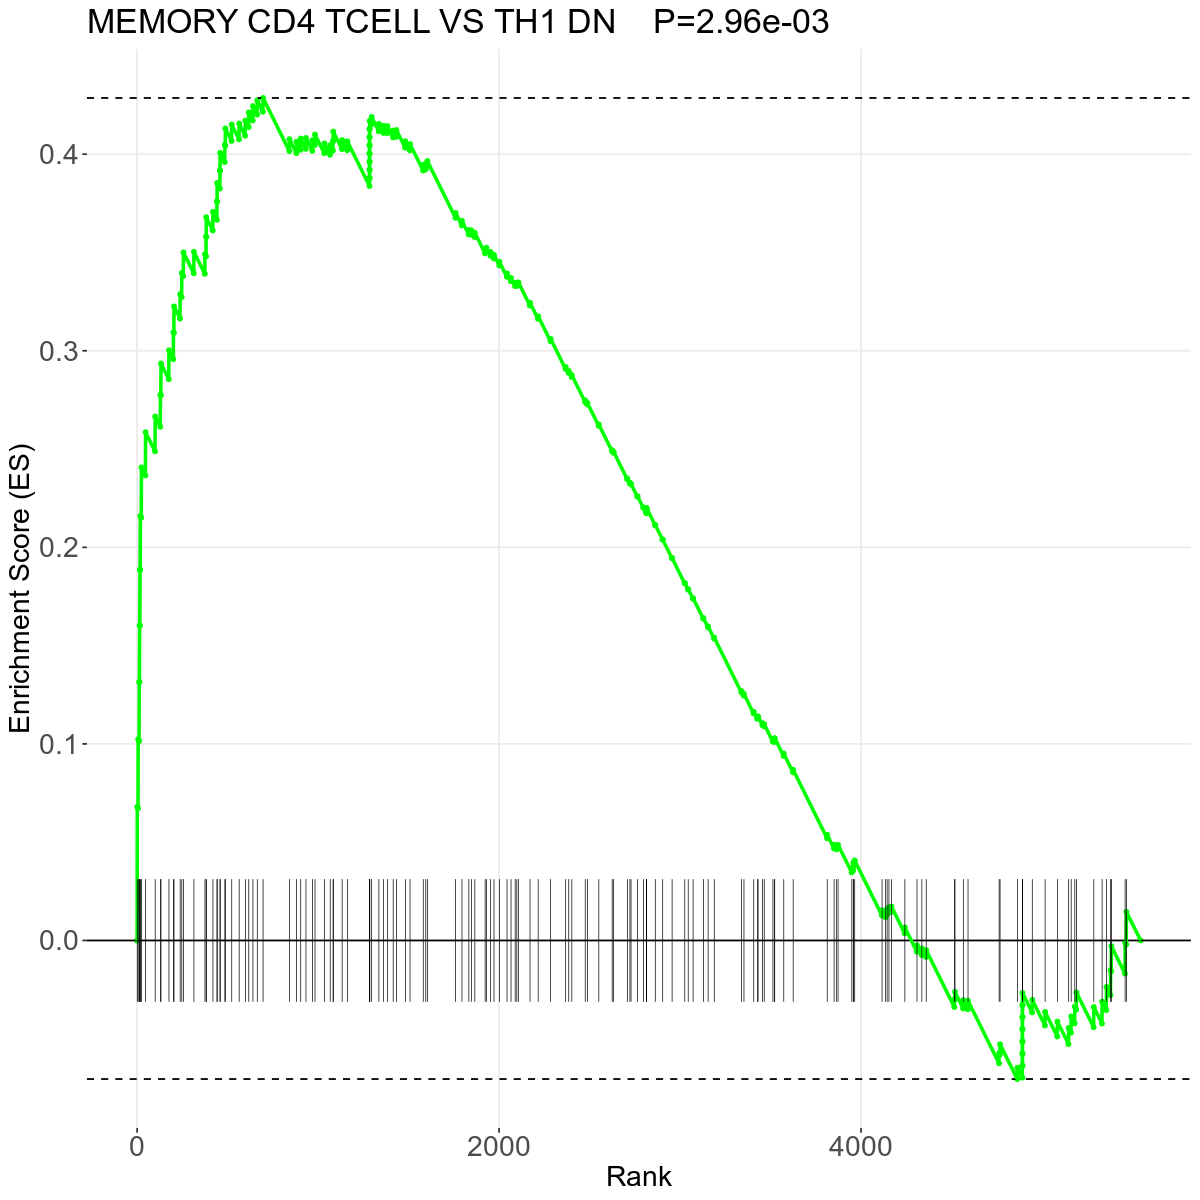

In [734]:
# pdf(file = '../Figures/GSEA_CD45_Memory_VS_Th1.pdf', width = 8, height = 5)
pname = 'GSE3982_MEMORY_CD4_TCELL_VS_TH1_DN'

p = plotEnrichment_mod(pathways[[pname]],
                   ranks) + 
    labs(title=paste0(pname %>% str_split('_', n = 2) %>% map(2) %>% unlist, '    P=', 
       res_filt[pname, 'padj'] %>% formatC(format = "e", digits = 2)) %>% str_replace_all('_', ' ')
        )
p

# dev.off()